# LIME

In [1]:
import sys
import h5py
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression

from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries

from matplotlib.colors import LinearSegmentedColormap

In [2]:
print('...')
print('--> VERSOES')
print("Versao python:", sys.version)
print("Versao de tensorflow:", tf.__version__)
print("Versao de Numpy:", np.__version__)

...
--> VERSOES
Versao python: 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
Versao de tensorflow: 2.3.0
Versao de Numpy: 1.20.0


In [ ]:
def LimeInterpreter(model, x_img, num_perturb, seg_method='grid', grid_size=[3,10]):
    '''
    Aplica o método LIME (Local Interpreter) em uma imagem aplicada no modelo classificador.
    
    Args.
        model: modelo treinado
        x_img: (1, im_height, im_width, 1) imagem a ser analisada
        seg_method: str com o método de segmentação utilizado
        num_perturb: número de perturbações geradas aleatoriamente
        grid_size: [h_ration, w_ration] int com quantidade de quadrados (h: height | w: width)
    
    Returns.
        Plots do resultado
        
    '''
    # Passo 1: Criar perturbações
    # -------------------------------------------------------------------------------------
    def to_rgb(img):
        '''
        Recebe imagem em grayscale (1 x height x width x 1) e copia para os outros canais, 
        retornando (1 x height x width x 3)

        '''
        x_rgb = np.zeros((img.shape[0],img.shape[1], img.shape[2], 3))

        for i in range(3):
            x_rgb[..., i] = img[..., 0]

        return x_rgb
    # -------------------------------------------------------------------------------------

    Xi = to_rgb(x_img) # converte para 3 canais
    Xi = Xi[0,...]

    # -------------------------------------------------------------------------------------
    # Segmentação

    # -------------------------------------------------------------------------------------
    def gridSegmentation(im, h_ratio, w_ratio):
        '''
        Define um Grid como Laberl array onde as regiões são marcadas por diferentes valores inteiros.

        Args.
            im: (im_height x im_width [, 3]) Grayscale or RGB image
            h_ration: [int] ration of squares in im_height
            w_ration: [int] ration of squares in im_width

        Returns.
            grid: (im_height x im_width [, 3]) Label array where regions are marked bu different integer values
        '''

        imgheight=im.shape[0]
        imgwidth=im.shape[1]

        i = 0
        M = imgheight//h_ratio
        N = imgwidth//w_ratio

        grid = np.ones((imgheight, imgwidth))

        for y in range(0,imgheight,M):
            for x in range(0, imgwidth, N):
                i = i+1
                grid[y:y+M, x:x+N] = i

        return grid
    # -------------------------------------------------------------------------------------

    #### ------------------------------ ####
    # Select segmentation method
    if seg_method == 'grid':
        superpixels = gridSegmentation(Xi, grid_size[0], grid_size[1]) # Segmentar em Grid
        
    elif seg_method == 'quickshift':
        superpixels = quickshift(Xi, kernel_size=10,max_dist=200, ratio=0.5)
        
    elif seg_method == 'slic':
        superpixels = slic(Xi, n_segments=20, compactness=10, sigma=1, start_label=1)
        
    elif seg_method == 'felzenszwalb':
        superpixels = felzenszwalb(Xi, scale=100, sigma=0.5, min_size=20)
        
    elif seg_method == 'watershed':
        gradient = sobel(rgb2gray(Xi))
        superpixels = watershed(gradient, markers=20, compactness=0.001)
        
    else:
        print('ERROR: Invalid segmentation method')
    
    #### ------------------------------ ####
    pd.DataFrame(superpixels).to_csv("ecgD2_LIMEsuperpixels.csv")
    #### ------------------------------ ####

    fig = plt.figure(figsize=(15,10))
    plt.imshow(mark_boundaries(Xi.astype(np.uint8), superpixels, mode='subpixels'))
    plt.title('Grid segmentation')
    plt.axis('off')
    fig.savefig('ecgD2_GridSegmentation.jpg')

    # - Número de superpixels gerado por cada método
    print(f'## Number of Superpixels: {len(np.unique(superpixels))}')

    # -------------------------------------------------------------------------------------
    # Criar perturbações aleatórias

    #### ------------------------------ ####
    print('## Segmentation method: ', seg_method)
    #### Numero de perturbações criadas ####
    print('## Number of Perturbations: ', num_perturb)
    #### ------------------------------ ####

    # Numero de superpixels
    num_superpixels = len(np.unique(superpixels))

    # Criar números aleatórios
    perturbations = np.random.binomial(1, 0.5, size = (num_perturb, num_superpixels))

    # -------------------------------------------------------------------------------------
    def perturb_image(img,perturbation,segments):
        '''
        Gera perturbações na imagem, baseado no vetor perturbations e nos superpixels (segments) definidos

        Args.
            img: (height x width x 3)
            perturbation: (num_perturb x num_superpixels)
            segments: (height x width) superpixels

        Returns.
            perturbed_image: (height x width x 3) com valores 0's e 1's correspondentes aos superpixels OFF e ON

        '''
        active_pixels = np.where(perturbation == 1)[0]
        mask = np.zeros(segments.shape)

        for active in active_pixels:
            mask[segments == active] = 1
            perturbed_image = copy.deepcopy(img)
            perturbed_image = perturbed_image * mask[:, :, np.newaxis]

        return perturbed_image
    # -------------------------------------------------------------------------------------

    # Apresentar exemplo de uma perturbação para cada método de sementação:
    #perturb_img = perturb_image(Xi, perturbations[0], superpixels)

    #fig1 = plt.figure(figsize=(15,10))
    #plt.imshow(perturb_img.astype(np.uint8))
    #plt.title('Perturbation example')
    #plt.axis('off')
    #fig1.savefig('ecgD2_PerturbationExample.jpg')

    # -------------------------------------------------------------------------------------
    # Passo 2: Usar o Modelo para predizer as classes das novas imagens geradas
    predictions = []
    for pert in perturbations:
        perturbed_img = perturb_image(Xi, pert, superpixels)
        x = perturbed_img[:, :, 0]
        x = x[np.newaxis, ..., np.newaxis]
        pred = model.predict(x)
        predictions.append(pred)    

    predictions = np.array(predictions)

    # -------------------------------------------------------------------------------------
    # ### Passo 3: Calcular distâncias entre imagem original e imagens perturbadas e computar os pesos (importâncias) de cada imagem perturbada
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled

    distances = sklearn.metrics.pairwise_distances(perturbations, original_image, metric='cosine').ravel()

    # -------------------------------------------------------------------------------------
    # Utilizar Função Kernel para computar os pesos
    kernel_width = 0.25

    weights = np.sqrt( np.exp ( - (distances ** 2) / kernel_width ** 2 ) ) #Kernel function

    # -------------------------------------------------------------------------------------
    # Passo 4: Utilizar `perturbations`, `predictions` e `weights` para gerar um modelo (linear) explicavel
    ## For Multiclass use:
    # class_to_explain = top_pred_classes[0]
    # simpler_model_qs = LinearRegression()
    # simpler_model_qs.fit(X=perturbations_qs, y=predictions[:,:,class_to_explain], sample_weight=weights)
    # coeff_qs = simpler_model_qs.coef_[0]

    simpler_model = LinearRegression()
    simpler_model.fit(X = perturbations, y = predictions[:,:,0], sample_weight = weights)

    coeff = simpler_model.coef_[0]
    pd.DataFrame(coeff).to_csv("ecgD2_LIMEcoeff.csv")
    
    # Passo 5: Definir os parametros para gerar resultados
    # -------------------------------------------------------------------------------------
    def fill_segmentation(values, segmentation):
        '''
        Preenche os segmentos com os valores associados a eles.

        '''
        out = np.zeros(segmentation.shape)

        for i in range(len(values)):
            out[segmentation == i] = values[i]

        return out
    # -------------------------------------------------------------------------------------

    # -------------------------------------------------------------------------------------
    # make a color map
    colors = []

    for l in np.linspace(1,0,100):
        colors.append((245/255,39/255,87/255,l))

    for l in np.linspace(0,1,100):
        colors.append((24/255,196/255,93/255,l))

    cm = LinearSegmentedColormap.from_list("shap", colors)
    # -------------------------------------------------------------------------------------
    
    # set max_val for plotting
    max_val_lime = np.max(coeff)

    # set fill segmentation
    m_lime = fill_segmentation(coeff, superpixels)
    
    # -------------------------------------------------------------------------------------
    # PLOT
    fig2 = plt.figure(figsize=(15,10))
    plt.title('LIME mask')
    plt.imshow(m_lime, cmap = cm, vmin = -max_val_lime, vmax = max_val_lime)
    plt.colorbar(label = "LIME value", orientation = "horizontal", aspect = 60)
    plt.axis('off')
    fig2.savefig('ecgD2_LIMEmask.jpg')
    
    fig_lime = plt.figure(figsize=(15,10))
    plt.title('LIME')
    plt.imshow(mark_boundaries(Xi.astype(np.uint8), superpixels, mode = 'subpixels'))
    plt.imshow(m_lime, cmap = cm, vmin = -max_val_lime, vmax = max_val_lime)
    plt.colorbar(label = "LIME coeff", orientation = "horizontal", aspect = 60)
    plt.axis('off')
    fig_lime.savefig('ecgD2_LIME.jpg')
    

In [3]:
if __name__ == '__main__':
    # Carregando modelo de classificação
    model = tf.keras.models.load_model('modelD2long.h5', compile=False)
    #model.summary()

    # Abrindo dataset de exemplo
    h5 = h5py.File('ecgD2longImgs.h5', 'r') # Open file
    data = h5['2d'] # D2 images
    
    # LOAD IMAGE
    # Artigo: normal (3) | fa (35)
    idx = 35

    x_img = data[idx] # FA
    x_img = np.expand_dims(x_img, axis = 0) # input shape nedded for the model

    print('## Image to be analyzed: ', idx)
    print('## Image prediction (NORMAL = 0 | FA = 1): ', int(model.predict(x_img)))
    
    grid_size = [3,10]
    num_perturb = 100
    seg_method = 'grid'
    
    # Aplica interpretador
    #LimeInterpreter(model, x_img, num_perturb, seg_method, grid_size)

## Image to be analyzed:  35
## Image prediction (NORMAL = 0 | FA = 1):  1


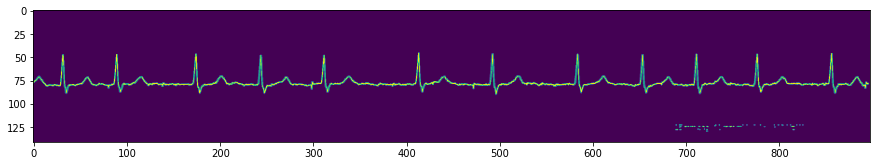

In [19]:
plt.figure(figsize=(15,10))
plt.imshow(x_img[0])

In [27]:
import cv2

ret, bw_img = cv2.threshold(x_img[0], 100, 255, cv2.THRESH_BINARY)

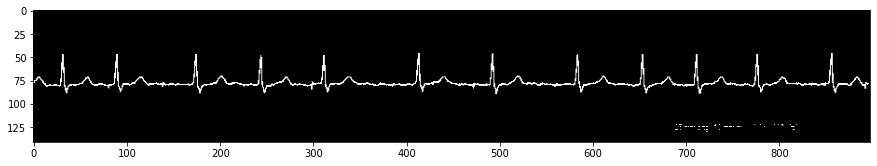

In [28]:
plt.figure(figsize=(15,10))
plt.imshow(bw_img, cmap='gray')